In [1]:
from lib.tgcf_dtc import TGCF_dtc
from lib.tgcf_imm import TGCF_imm
from lib.tgcf_rf import TGCF_rf
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer, load_diabetes

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

# Create dataset and perform Clustering

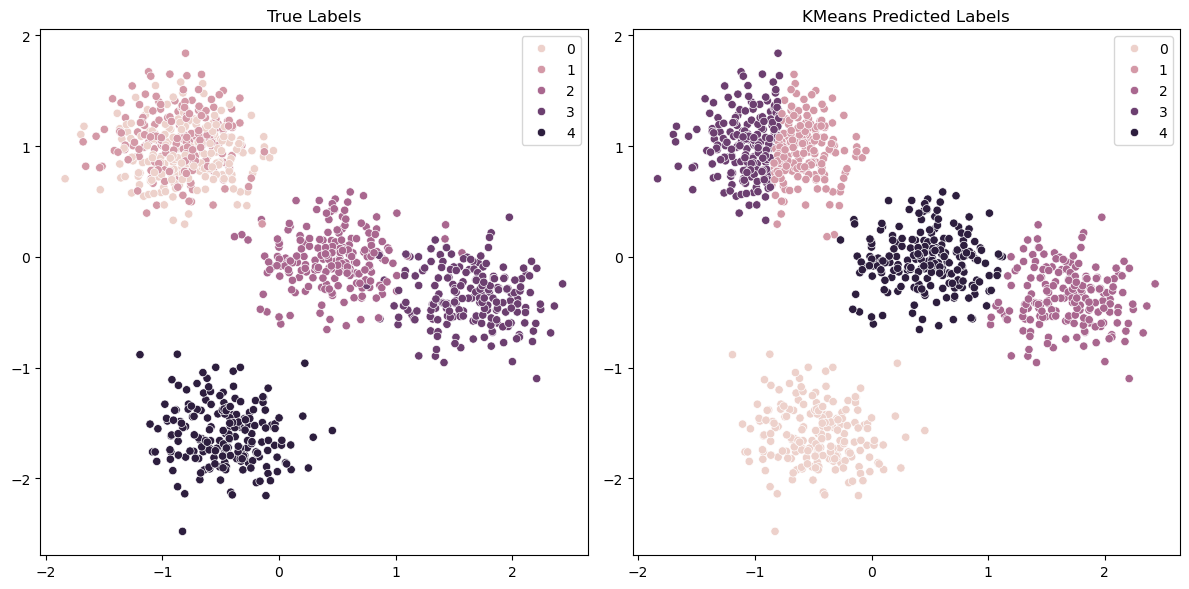

[[ 1.78447518 -0.29408894]
 [ 0.61978154  0.16625335]
 [-0.00043477  0.08806306]
 [-1.0309419   0.80265961]
 [ 2.11645208 -0.16241545]
 [-0.77608119 -1.32921999]
 [-0.56603907  0.97665333]
 [-0.8145052   1.27038028]
 [-0.77084943  0.81057365]
 [-0.58653653 -1.65918366]]


In [2]:
dims = 2
n = 1000
seed = 5
k = 5
# seed = 41
# k = 5
min_impurity_decrease = 0.1 # minimum impurity decrease to split for DTC
threshold_change = 0.01 # amount that will be changed to either side of the threshold
robustness_factor = 0.3 # DTC robustness post processing factor

X, _y = make_blobs(centers=k, cluster_std=1.4, n_features=dims, n_samples=n, random_state=seed)
# data = load_iris()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k, random_state=seed)
model.fit(X)

centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]
k = len(centers)

# plot the clusters
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels
if dims > 2:
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")

# Plot with KMeans labels
if dims > 2:
    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

print(X[:10])

# Choose instance and target

In [3]:
instance_index = np.where(y == 2)[0][0] # Instance class index
instance = X[instance_index]
target_class = 0
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 2, point: [ 1.78447518 -0.29408894]
Target center class: 0, point: [-0.45807102 -1.60062861]



# Find cfs using Decision Tree Classifier

DTC accuracy: 0.964


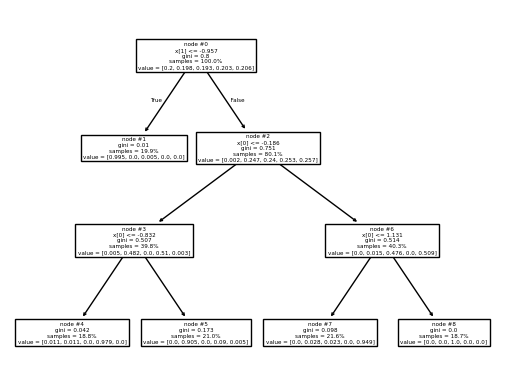

Instance: [ 1.78447518 -0.29408894]
Instance prediction : [2]

CFS: [[ 1.78447521 -0.9671061 ]]
CF predictions:  [2]
CFs prime: [[ 1.78447521 -1.15716286]]
CFs prime predictions:  [2]


In [4]:
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=False, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, False, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

tgcf_dtc.print_tree()
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))

# Find cfs using Iterative Mistake Minimization(IMM)

In [5]:

tgcf_imm = TGCF_imm(model, centers, X, y)
tgcf_imm.fit()
cf = tgcf_imm.find_counterfactuals(instance, target_class, threshold_change=threshold_change)
cf_prime = tgcf_imm.plausibility_fix(cf, instance, target_class, robustness_factor)

print("Instance: ", instance)
print("Original class: ", model.predict([instance]))
print("Counterfactual: ", cf)
print("Counterfactual class: ", model.predict(cf))
print("")
print("Counterfactual prime: ", cf_prime)
print("Counterfactual prime class: ", model.predict(cf_prime))
tgcf_imm.print_tree()

Instance:  [ 1.78447518 -0.29408894]
Original class:  [2]
Counterfactual:  [[ 0.29858438 -0.29408894]]
Counterfactual class:  [4]

Counterfactual prime:  [[ 0.07158776 -0.29408894]]
Counterfactual prime class:  [4]
├── L0: f0 < 0.30858438457346893
│   ├── L1: f1 < -0.28929017948018343
│   │   ├── L2, C: 0
│   │   └── L2: f0 < -0.8191360215251253
│   │       ├── L3, C: 3
│   │       └── L3, C: 1
│   └── L1: f0 < 1.0779500010613818
│       ├── L2, C: 4
│       └── L2, C: 2



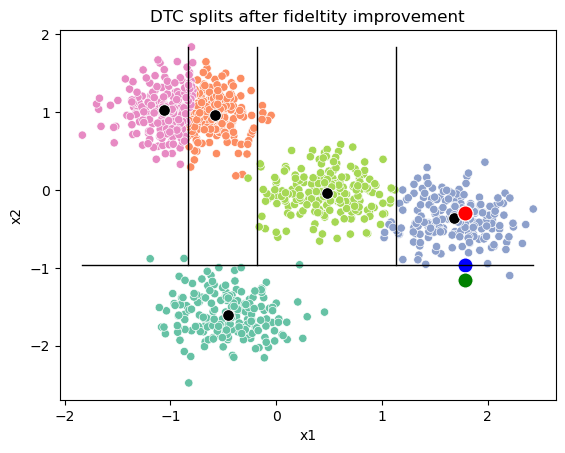

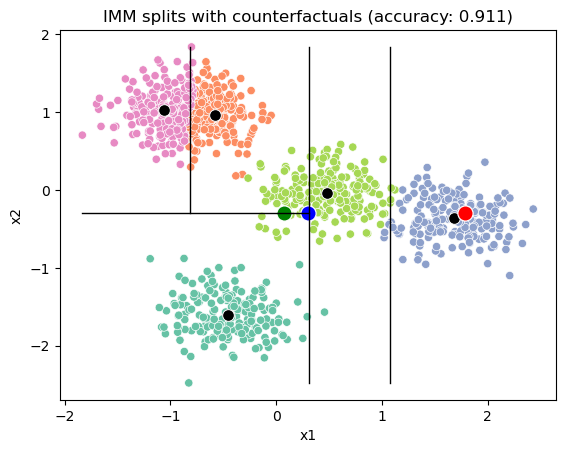

In [6]:
if dims == 2:
    tgcf_dtc.plot_tree()
    tgcf_imm.plot_tree()
else:
    print("Plotting is only supported for 2D data. Skipping tree plots.")

# Threshold Tree DTC normal vs fidelity improvement

DTC accuracy: 0.964
Instance prediction : [2]
CF predictions:  [2]
CFs prime predictions:  [2]


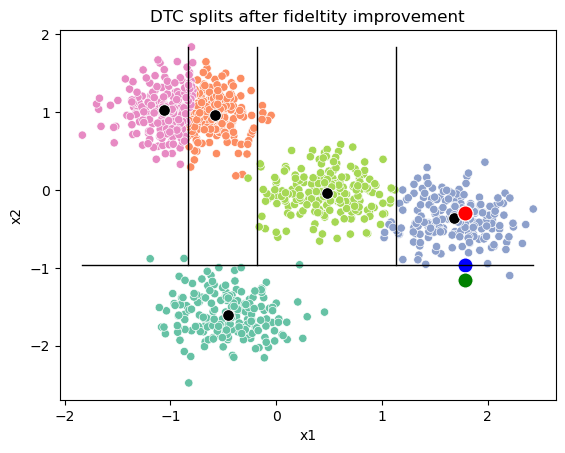

DTC accuracy: 0.964
Instance prediction : [2]
CF predictions:  [0 0 0]
CFs prime predictions:  [0 0 0]


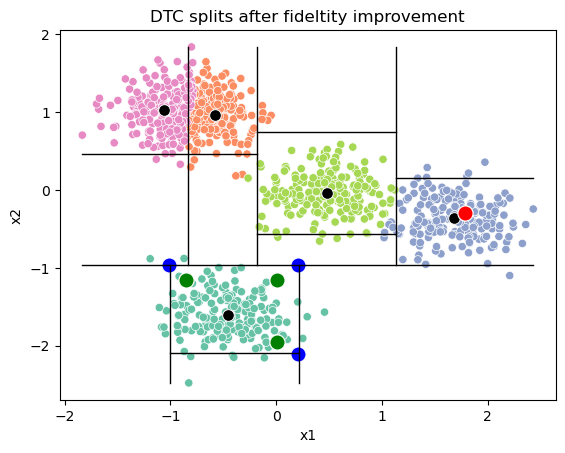

In [11]:
# Normal method
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=False, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, False, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

# print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
# print("")
# print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
# print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))
tgcf_dtc.plot_tree()



# Fidelity improvement
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=True, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, True, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

# print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
# print("")
# print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
# print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))
tgcf_dtc.plot_tree()

# Find cfs using Random Forest Classifier

Random Forest accuracy: 0.996


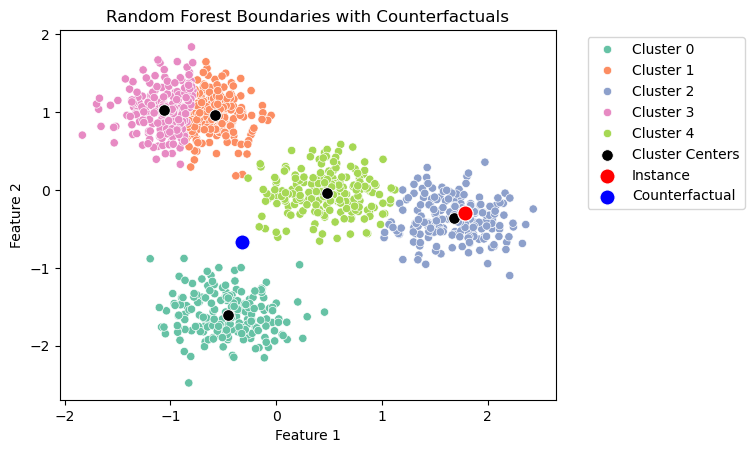

In [8]:
tgcf_rf = TGCF_rf(model, centers, X, y)
tgcf_rf.fit()
cf = tgcf_rf.find_counterfactuals(instance, target_class, threshold_change=threshold_change, ratio_of_trees=0.4)
tgcf_rf.plot_tree()